In [34]:
# !pip install ucimlrepo
# !pip install -U scikit-learn
# !pip install xgboost
# !pip install imblearn

## Income Prediction

#### Import required packages

In [47]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt


#### Pull Data

In [3]:
adult = fetch_ucirepo(id=2) 
X = adult.data.features 
y = adult.data.targets 

#### Explore Data

In [4]:
print (f'(Dataframes: {adult.keys()})')

print(f'(Columns in Data: {adult.data.keys()})')

print(f'(Columns in metadata: {adult.metadata.keys()})')

print(f'(Columns in variables: {adult.variables.keys()})')

(Dataframes: dict_keys(['data', 'metadata', 'variables']))
(Columns in Data: dict_keys(['ids', 'features', 'targets', 'original', 'headers']))
(Columns in metadata: dict_keys(['uci_id', 'name', 'repository_url', 'data_url', 'abstract', 'area', 'tasks', 'characteristics', 'num_instances', 'num_features', 'feature_types', 'demographics', 'target_col', 'index_col', 'has_missing_values', 'missing_values_symbol', 'year_of_dataset_creation', 'last_updated', 'dataset_doi', 'creators', 'intro_paper', 'additional_info']))
(Columns in variables: Index(['name', 'role', 'type', 'demographic', 'description', 'units',
       'missing_values'],
      dtype='object'))


#### Target value

['<=50K' '>50K' '<=50K.' '>50K.']
income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64


/var/folders/s4/zwbs2tpd6t938czhj3blkbk40000gn/T/ipykernel_10918/3360093174.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[:, 'income_mapped'] = y['income'].map(target_mapping)


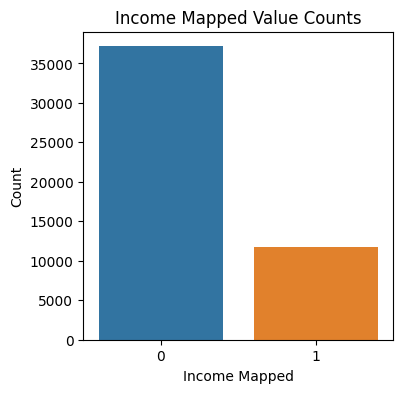

In [5]:
print(y['income'].unique())
print(y['income'].value_counts())

target_mapping = {'<=50K.' : 0,  '<=50K' : 0, '>50K.': 1, '>50K': 1}

y.loc[:, 'income_mapped'] = y['income'].map(target_mapping)

plt.figure(figsize=(4, 4))
sns.countplot(x='income_mapped', data=y)
plt.title('Income Mapped Value Counts')
plt.xlabel('Income Mapped')
plt.ylabel('Count')
plt.show()

#### Preprocessing the features

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


In [7]:
X.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [8]:
X.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [9]:
print(f"The column age ranges from  {min(X['age'])} to  {max(X['age'])}")
print(f"The column workclass has values  {set(X['workclass'])}")
print(f"The column education-num has values  {set(X['education-num'])}")
print(f"The column education has values  {set(X['education'])}")
print(f"The column marital-status has values  {set(X['marital-status'])}")
print(f"The column relationship has values  {set(X['relationship'])}")
print(f"The column race has values  {set(X['race'])}")
print(f"The column sex has values  {set(X['sex'])}")
print(f"The column hours-per-week ranges from  {min(X['hours-per-week'])} to  {max(X['hours-per-week'])}")
print(f"The column native-country has values  {set(X['native-country'])}")

The column age ranges from  17 to  90
The column workclass has values  {nan, 'Never-worked', 'Local-gov', 'Private', 'Self-emp-inc', 'Federal-gov', 'Self-emp-not-inc', 'Without-pay', 'State-gov', '?'}
The column education-num has values  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
The column education has values  {'Masters', '9th', '5th-6th', '7th-8th', '11th', '1st-4th', 'Doctorate', 'Bachelors', 'Preschool', 'Prof-school', 'HS-grad', '10th', 'Assoc-acdm', '12th', 'Assoc-voc', 'Some-college'}
The column marital-status has values  {'Married-spouse-absent', 'Married-civ-spouse', 'Married-AF-spouse', 'Never-married', 'Divorced', 'Separated', 'Widowed'}
The column relationship has values  {'Own-child', 'Not-in-family', 'Unmarried', 'Other-relative', 'Husband', 'Wife'}
The column race has values  {'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'White', 'Other'}
The column sex has values  {'Male', 'Female'}
The column hours-per-week ranges from  1 to  99
The column native-

In [10]:
def questionmark_to_nan(df, col_name):
    '''
    Replaces '?' with nan

    Params: 
        df : Dataframe
        col_name: The name of column with ?

    Returns
        Updated dataframe
    '''

    df.loc[:, col_name] = df.loc[:, col_name].replace('?', np.nan)
    return df


def categorize_marital_status(df):
    '''
    Convert the column marital status into Married, Not Married

    Params: df

    Returns: Updtaed df
    
    '''
    mapping = {'Married-spouse-absent': 'Married', 'Married-AF-spouse': 'Married', 'Separated': 'Not Married', 'Never-married': 'Not Married', 'Divorced': 'Not Married', 'Married-civ-spouse': 'Married', 'Widowed': 'Not Married'}
    df.loc[:, 'marital-status'] = df.loc[:, 'marital-status'].map(mapping)
    return df

In [11]:
df = X.copy()

# Replace null values with most frequent value
print(df.isna().sum())

for col in ['workclass', 'occupation', 'native-country']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Feature engineering
for col in df.columns:
    df= questionmark_to_nan(df, col)
df=categorize_marital_status(df)
df = df.drop_duplicates()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64


In [81]:
# Convert categorical values into numerical values

le = preprocessing.LabelEncoder()

categorical_columns = ['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'race', 'native-country']
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

df_of_interest = df[['age', 'workclass', 'education-num','marital-status', 'occupation', 'relationship', 'capital-gain','capital-loss', 
                    'race', 'sex', 'hours-per-week', 'native-country']]

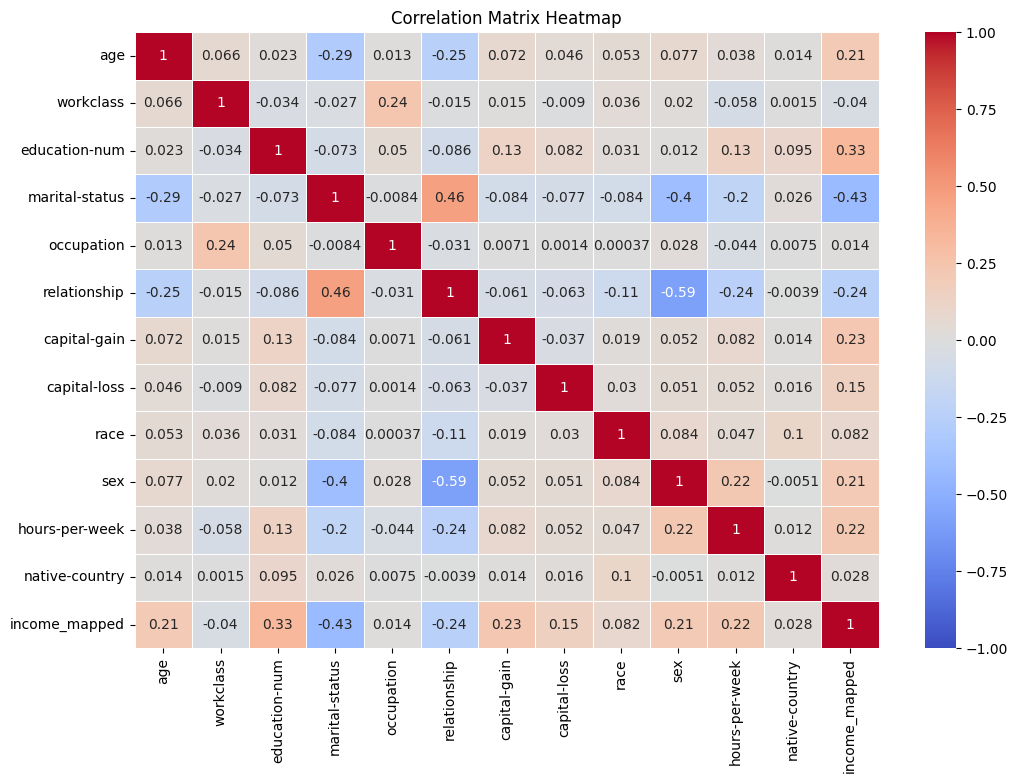

In [82]:
# Visualize relation of each feature with the outcome
combined_df = pd.concat([df_of_interest, y[['income_mapped']]], axis=1)
combined_df = combined_df.drop_duplicates()
combined_df = combined_df.dropna()

corr_matrix = combined_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


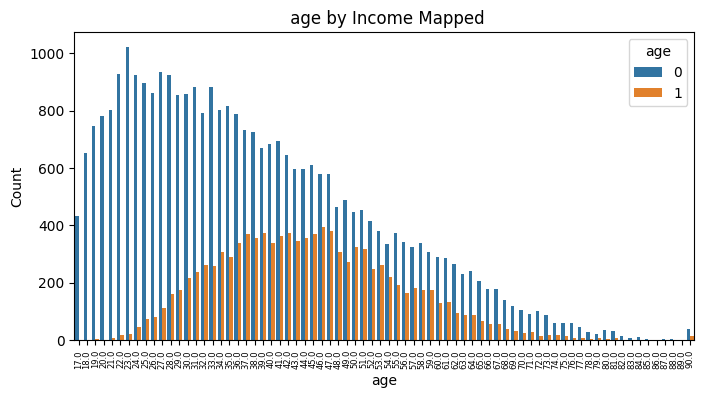

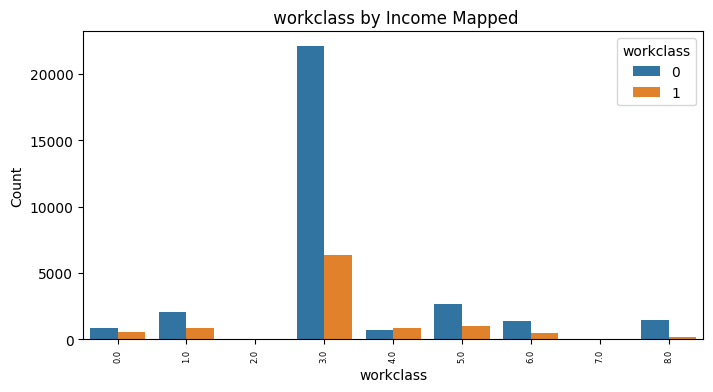

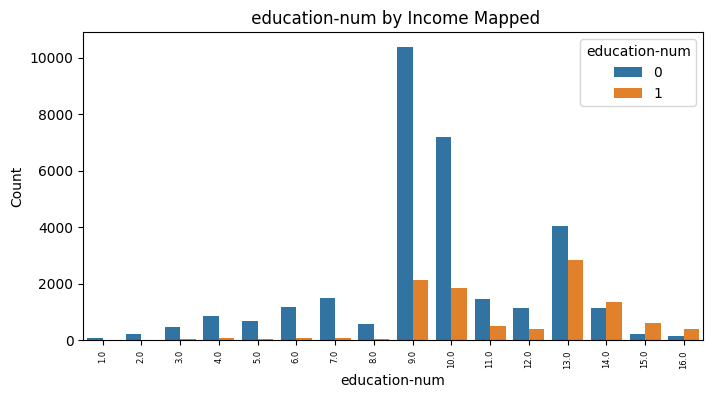

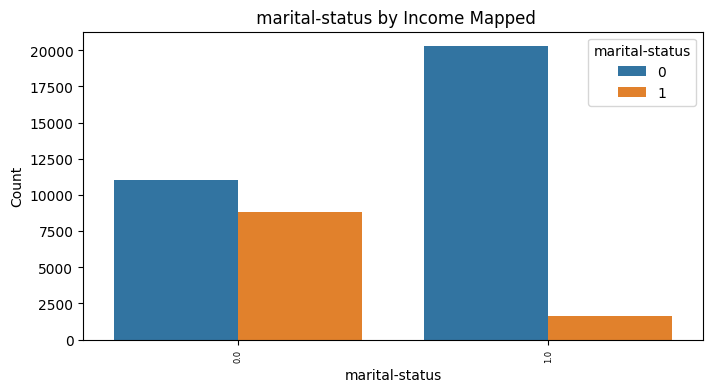

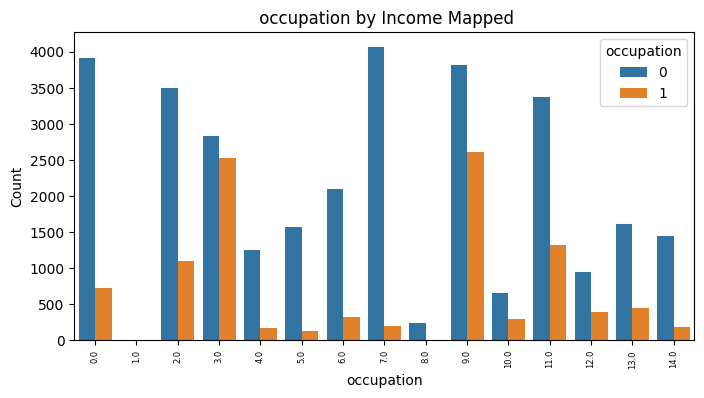

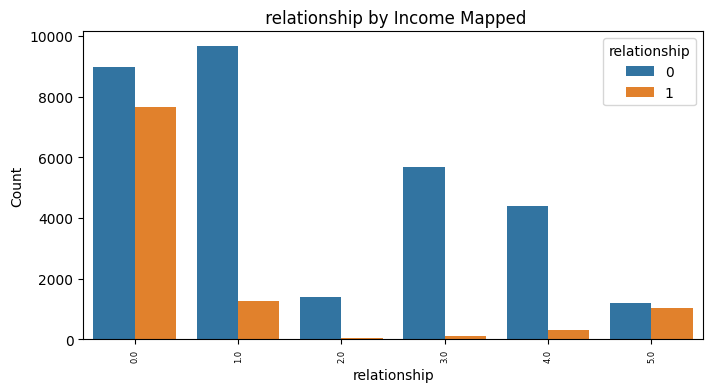

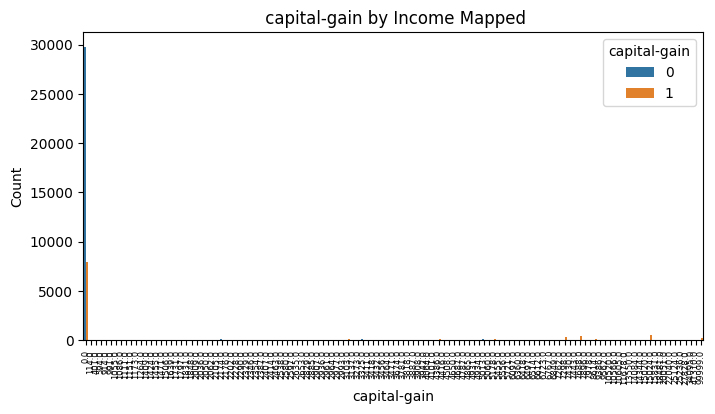

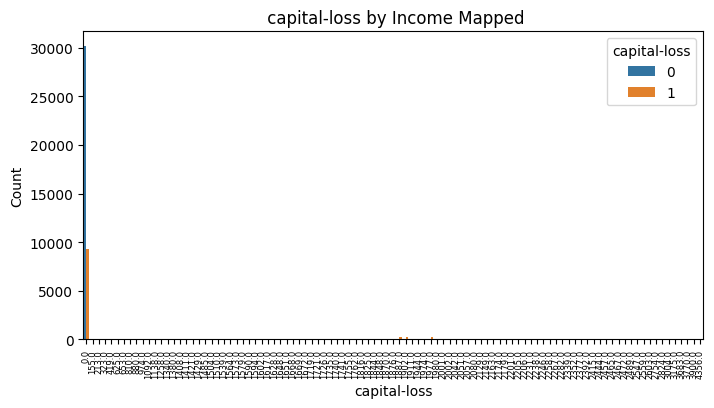

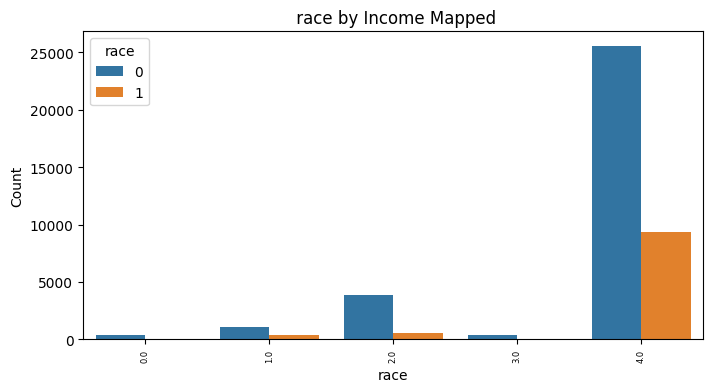

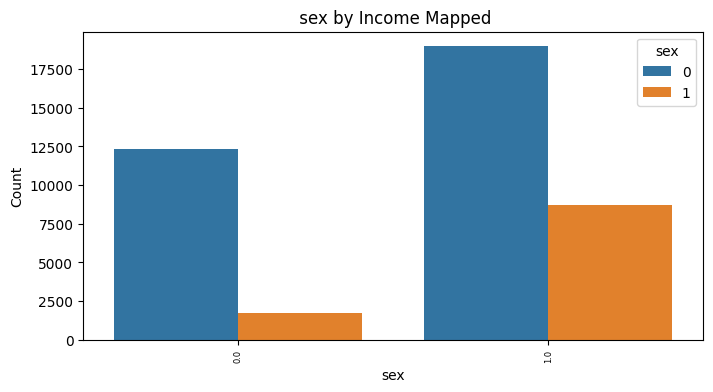

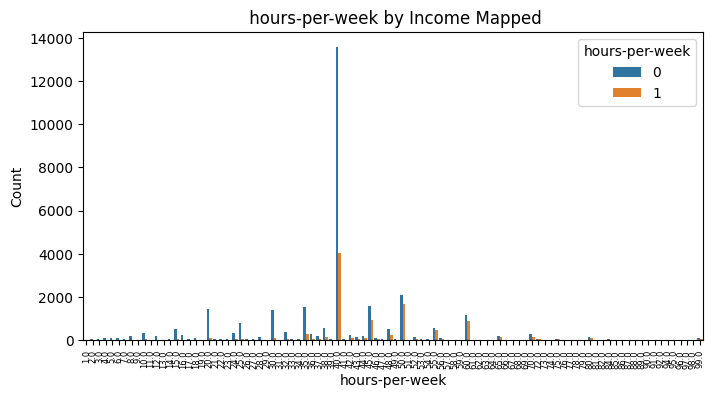

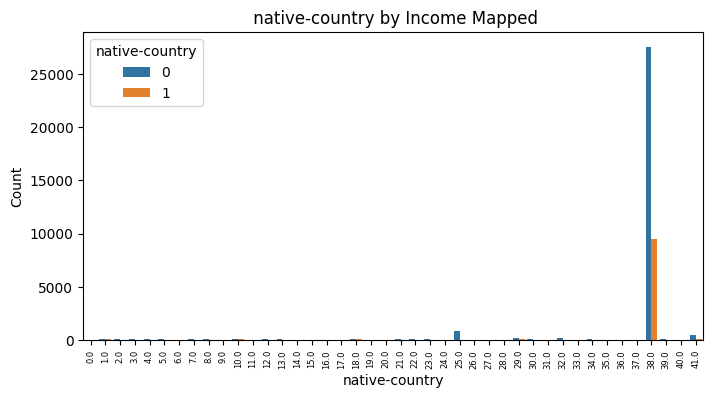

In [83]:
for col in df_of_interest.columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=combined_df, x=col, hue='income_mapped')
    plt.title(f' {col} by Income Mapped')
    plt.xlabel(f'{col}')
    plt.ylabel('Count')
    plt.xticks(rotation=90, fontsize=6)
    plt.legend(title=f'{col}')
    plt.show()

#### Model

In [84]:
final_interest_cols = ['age', 'education-num','marital-status',  'relationship',   'sex', 'hours-per-week', 'native-country', 'capital-gain','capital-loss', ]
Features = combined_df[final_interest_cols]

Y= combined_df['income_mapped']

In [85]:
x_train, x_test, y_train, y_test = train_test_split(Features , Y, test_size = 0.3)

ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)
X_resampled_scaled = scaler.fit_transform(x_resampled)

In [86]:
model = LogisticRegression(penalty='l2')
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [87]:
print('model score is: ' + str(round(model.score(X_test_scaled, y_test)* 100, 0)) + '%')

model score is: 83.0%


In [88]:
model = xgb.XGBClassifier( eval_metric='logloss')

# Fit the model
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

print('Classification Report:')
print(class_report)

Accuracy: 85.81%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      9219
           1       0.23      0.19      0.21      2861

    accuracy                           0.66     12080
   macro avg       0.50      0.50      0.50     12080
weighted avg       0.64      0.66      0.65     12080



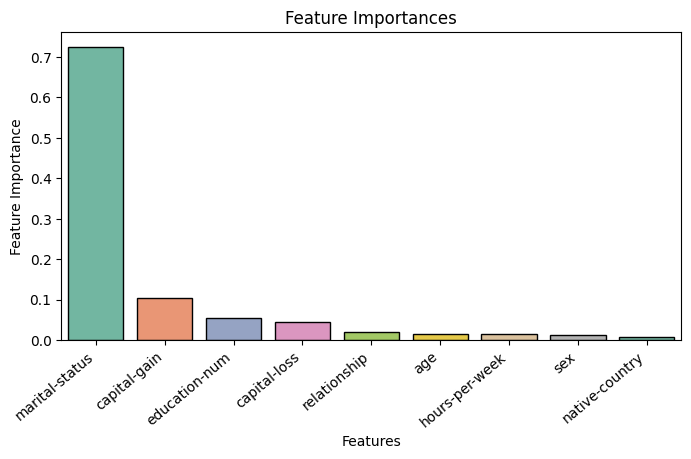

In [89]:
model=xgb.XGBClassifier()
model.fit(x_train, y_train)
feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
feat_importances=feat_importances.nlargest(x_train.shape[1])

plt.figure(figsize=(8, 4))
sns.barplot(x=feat_importances.index, y=feat_importances.values, edgecolor='k', palette='Set2')
plt.ylabel('Feature Importance')
plt.xlabel('Features')
plt.xticks(rotation=40, ha="right")
plt.title('Feature Importances')
plt.show()

In [90]:
f2 = Features[['age', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'capital-gain','capital-loss' ]]

In [91]:
scaler = StandardScaler()
X_scaled_1 = scaler.fit_transform(f2)

In [93]:
model = xgb.XGBClassifier()

accuracy_scores = cross_val_score(model, X_scaled_1, Y, cv=5, scoring='accuracy')

print(f'Accuracy scores for each fold: {accuracy_scores}')
print(f'Mean accuracy: {accuracy_scores.mean() * 100:.2f}%')
print(f'Standard deviation: {accuracy_scores.std() * 100:.2f}%')

Accuracy scores for each fold: [0.85784431 0.85964072 0.86213918 0.85782728 0.86309738]
Mean accuracy: 86.01%
Standard deviation: 0.22%
